<a href="https://colab.research.google.com/github/alexathomases/covid19-classification/blob/main/475_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Downloading Dataset

In [ ]:
# mount Google Drive (must do every time to access saved files)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Configure Kaggle API
import os
os.environ['KAGGLE_USERNAME'] = "alexholzbach" # username from the kaggle json file
os.environ['KAGGLE_KEY'] = "2d7d33825c5a175807651729ce5e80d3" # key from the kaggle json file

In [ ]:
!cd drive/Shareddrives/'475 Final Project'/datasets

In [ ]:
# download dataset into the notebook
!kaggle datasets download -d maedemaftouni/large-covid19-ct-slice-dataset

100% 2.05G/2.06G [00:18<00:00, 148MB/s]
100% 2.06G/2.06G [00:18<00:00, 122MB/s]


In [ ]:
# store dataset in shared drive
!mv '/content/large-covid19-ct-slice-dataset.zip' '/content/drive/Shareddrives/475 Final Project/datasets'

In [ ]:
!unzip '/content/drive/Shareddrives/475 Final Project/datasets/large-covid19-ct-slice-dataset.zip'

In [ ]:
!mv '/content/curated_data' '/content/drive/Shareddrives/475 Final Project/datasets'

In [ ]:
!mv '/content/meta_data_normal.csv' '/content/drive/Shareddrives/475 Final Project/datasets'

#Start Code

In [ ]:
import pandas as pd
from pathlib import Path
import os
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt, image as img
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import (
    Conv2D,
    Conv2DTranspose,
    MaxPool2D,
    ReLU,
    Flatten,
    Dense,
    UpSampling2D,
    Dropout,
    Input, 
    Concatenate,
    GlobalAveragePooling2D, 
    GlobalMaxPooling2D,
)
from skimage.transform import resize
from tensorflow import Tensor
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Input
from tensorflow import Tensor
from scipy.stats import mannwhitneyu
from tabulate import tabulate

!pip3 install progressbar
import progressbar

# random seed generator
np.random.seed(3)
tf.random.set_seed(7)

  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=26b51a27b56eef74bf0643fd11d34a83cd61fda6f7d6e68486dfce93f5d55d07
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar


In [ ]:
metadata = pd.read_csv(path, encoding='cp720')
metadata.drop_duplicates(["Patient ID"], inplace=True)
filenames = np.array(metadata["File name"])
filepaths = [path + "/" + img for img in filenames]
print(filepaths)

NameError: ignored

In [ ]:

def get_disctinct_filepaths(metadatapath, imgdirpath):
  metadata = pd.read_csv(metadatapath, encoding="cp720")
  metadata.drop_duplicates(["Patient ID"], inplace=True)
  filenames = np.array(metadata["File name"])
  filepaths = [imgdirpath + "/" + img for img in filenames]

  num_patients = len(metadata["Patient ID"])
  print(f"Found {num_patients} unique patients at {imgdirpath}")
  return filepaths

In [ ]:
def load_raw_data():
  #filepaths for metadata
  metacovpath = "/content/drive/Shareddrives/475 Final Project/datasets/meta_data_covid.csv"
  metanonpath = "/content/drive/Shareddrives/475 Final Project/datasets/meta_data_normal.csv"
  metacappath = "/content/drive/Shareddrives/475 Final Project/datasets/meta_data_cap.csv"

  #filepaths for images
  imgcovpath = "/content/drive/Shareddrives/475 Final Project/datasets/curated_data/curated_data/2COVID"
  imgnonpath = "/content/drive/Shareddrives/475 Final Project/datasets/curated_data/curated_data/1NonCOVID"
  imgcappath = "/content/drive/Shareddrives/475 Final Project/datasets/curated_data/curated_data/3CAP"

  #distinct patients in each
  covid_images = get_disctinct_filepaths(metacovpath, imgcovpath)
  non_covid_images = get_disctinct_filepaths(metanonpath, imgnonpath)
  cap_images = get_disctinct_filepaths(metacappath, imgcappath)
  
  #Showing imagess
  fig = plt.figure(figsize=(10, 10))
  fig.add_subplot(1, 2, 1)
  image = img.imread(covid_images[1])
  plt.imshow(image)
  plt.title("CT Scan of Lungs with COVID-19")

  fig.add_subplot(1, 2, 2)
  image = img.imread(non_covid_images[1])
  plt.imshow(image)
  plt.title("CT Scan of Normal Lungs")
  return covid_images, non_covid_images, cap_images

In [ ]:
covid_images, non_covid_images, cap_images = load_raw_data()

Found 464 unique patients at /content/drive/Shareddrives/475 Final Project/datasets/curated_data/curated_data/2COVID
Found 604 unique patients at /content/drive/Shareddrives/475 Final Project/datasets/curated_data/curated_data/1NonCOVID
Found 54 unique patients at /content/drive/Shareddrives/475 Final Project/datasets/curated_data/curated_data/3CAP


In [ ]:
IMG_SIZE = 256

# Three empty numpy arrays to store coverted images
positive_npy = np.empty((len(covid_images), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
negative_npy = np.empty((len(non_covid_images), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
cap_npy = np.empty((len(cap_images), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

# start a bar of show percentage of loading data 
# covid_bar = progressbar.ProgressBar(maxval=len(covid_images), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
# non_covid_bar = progressbar.ProgressBar(maxval=len(non_covid_images), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
# cap_bar = progressbar.ProgressBar(maxval=len(cap_images), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

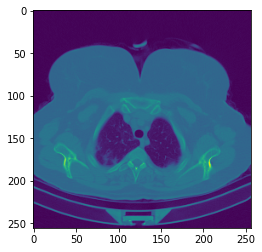

In [ ]:
test_img = img.imread(covid_images[4])
test_resize = resize(test_img, (IMG_SIZE, IMG_SIZE), anti_aliasing=True)
plt.imshow(test_resize)

In [ ]:
# covid_bar.start()
# Converting COVID dataset to .npy format
k = len(covid_images)
for i, _file in enumerate(covid_images):
    try:
        image_npy = img.imread(_file)
        positive = resize(image_npy, (IMG_SIZE, IMG_SIZE, 1), anti_aliasing=True)
        positive_npy[i] = positive
    except:
        pass
    if i%20 == 0:
      print(i/k)
    # covid_bar.update(i+1)
# covid_bar.finish()
print("COVID images converting done")

0.0
0.04310344827586207
0.08620689655172414
0.12931034482758622
0.1724137931034483
0.21551724137931033
0.25862068965517243
0.3017241379310345
0.3448275862068966
0.3879310344827586
0.43103448275862066
0.47413793103448276
0.5172413793103449
0.5603448275862069
0.603448275862069
0.646551724137931
0.6896551724137931
0.7327586206896551
0.7758620689655172
0.8189655172413793
0.8620689655172413
0.9051724137931034
0.9482758620689655
0.9913793103448276
COVID images converting done


In [ ]:
# non_covid_bar.start()
k = len(non_covid_images)
# Converting non-COVID dataset to .npy format
for i, _file in enumerate(non_covid_images):
    try:
        image_npy = img.imread(_file)
        negative = resize(image_npy, (IMG_SIZE, IMG_SIZE, 1), anti_aliasing=True)
        negative_npy[i] = negative
    except:
        print("cant open image " + i + "th") 
    # non_covid_bar.update(i+1)
    if i%20 == 0:
      print(i/k)
# non_covid_bar.finish()
print("non covid images converting done")     

0.0
0.033112582781456956
0.06622516556291391
0.09933774834437085
0.13245033112582782
0.16556291390728478
0.1986754966887417
0.23178807947019867
0.26490066225165565
0.2980132450331126
0.33112582781456956
0.36423841059602646
0.3973509933774834
0.4304635761589404
0.46357615894039733
0.4966887417218543
0.5298013245033113
0.5629139072847682
0.5960264900662252
0.6291390728476821
0.6622516556291391
0.695364238410596
0.7284768211920529
0.7615894039735099
0.7947019867549668
0.8278145695364238
0.8609271523178808
0.8940397350993378
0.9271523178807947
0.9602649006622517
0.9933774834437086
non covid images converting done


In [ ]:
# cap_bar.start()
# Converting non-COVID dataset to .npy format
k = len(cap_images)
for i, _file in enumerate(cap_images):
    try:
        image_npy = img.imread(_file)
        cap = resize(image_npy, (IMG_SIZE, IMG_SIZE, 1), anti_aliasing=True)
        cap_npy[i] = cap
    except:
        print("cant open image " + i + "th") 
    if i%20 == 0:
      print(i/k)
    # cap_bar.update(i+1)
# cap_bar.finish()
print("cap images converting done") 

0.0
0.37037037037037035
0.7407407407407407
cap images converting done


In [ ]:
print(positive_npy.shape)
print(negative_npy.shape)
print(cap_npy.shape)

(464, 256, 256, 1)
(604, 256, 256, 1)
(54, 256, 256, 1)


In [ ]:
# To load .npy datasets
def load_data():
    capnum = 11
    posnum = 93
    negnum = 121
    cap = cap_npy
    cap_labels = [2 for i in cap]
    cap_test = cap[:capnum,:,:,:]
    cap_train = cap[capnum:,:,:,:]
    positive = positive_npy
    positive_labels = [0 for i in positive]
    positive_test = positive[:posnum,:,:,:]
    positive_train = positive[posnum:,:,:,:]
    negative = negative_npy
    negative_labels = [1 for i in negative]
    negative_test = negative[:negnum,:,:,:]
    negative_train = negative[negnum:,:,:,:]

    # Joining both datasets and labels
    X_train = np.concatenate([positive_train, negative_train, cap_train])
    X_test = np.concatenate([positive_test, negative_test, cap_test])
    y_train = np.concatenate([positive_labels[posnum:], negative_labels[negnum:], cap_labels[capnum:]])
    y_test = np.concatenate([positive_labels[:posnum], negative_labels[:negnum], cap_labels[:capnum]])
    return X_train, X_test, y_train, y_test

In [ ]:
# save x and y
X_train, X_test, y_train, y_test = load_data()
np.savez('X_train', X_train)
np.savez('X_test', X_test)
np.savez('y_train', y_train)
np.savez('y_test', y_test)

In [ ]:
!mv '/content/y_test.npz' '/content/drive/Shareddrives/475 Final Project'

In [ ]:
# load in 
dataX_train = np.load('/content/drive/Shareddrives/475 Final Project/X_train.npz')
dataX_test = np.load('/content/drive/Shareddrives/475 Final Project/X_test.npz')
datay_train = np.load('/content/drive/Shareddrives/475 Final Project/y_train.npz')
datay_test = np.load('/content/drive/Shareddrives/475 Final Project/y_test.npz')
X_train = dataX_train['arr_0']
X_test = dataX_test['arr_0']
y_train = datay_train['arr_0']
y_test = datay_test['arr_0']

In [ ]:
# print(X.shape)
# print(y.shape)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_hot = keras.utils.to_categorical(y_train, 3)
y_test_hot =  keras.utils.to_categorical(y_test, 3)

In [ ]:
VGG = tf.keras.applications.VGG19(weights='imagenet', include_top=False)
VGG.trainable =False
for i, layer in enumerate(VGG.layers):
  print(i, layer.name)

for layer in VGG.layers[:-5]:
   layer.trainable = False
for layer in VGG.layers[-5:]:
   layer.trainable = True
for layer in VGG.layers:
    print(layer, layer.trainable) 

VGG.summary()

80150528/80134624 [==============================] - 1s 0us/step
0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
<keras.engine.input_layer.InputLayer object at 0x7f3262bdc3d0> False
<keras.layers.convolutional.Conv2D object at 0x7f325eed4b10> False
<keras.layers.convolutional.Conv2D object at 0x7f325b5af990> False
<keras.layers.pooling.MaxPooling2D object at 0x7f325acef110> False
<keras.layers.convolutional.Conv2D object at 0x7f3250785a50> False
<keras.layers.convolutional.Conv2D object at 0x7f3250788a50> False
<keras.layers.pooling.MaxPooling2D object at 0x7f325078cc10> False
<keras.layers.convolutional.Conv2D object at 0x7f3250794590> False
<keras.layers.convolutional.Conv2D object at 0x7f325079d2d0> Fals

In [ ]:
def cnn(): 
    from tensorflow.keras.layers import Input, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate
    from tensorflow.keras.models import Model
    VGG = tf.keras.applications.VGG19(weights='imagenet', include_top=False)
    for layer in VGG.layers[:-5]:
      layer.trainable = False
    for layer in VGG.layers[-5:]:
      layer.trainable = True
    
    input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = VGG(x , training=False)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(3, activation="softmax", name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [ ]:
model = cnn()
model.summary()

annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(rotation_range=180, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically
BATCH_SIZE = 64
datagen.fit(X_train)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 3)       30        
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(X_train, y_train_hot, batch_size=BATCH_SIZE,
               epochs=20,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_test, y_test_hot))

Epoch 1/20
15/15 [==============================] - ETA: 0s - loss: 1.2074 - accuracy: 0.5619  
Epoch 1: val_loss improved from inf to 0.80035, saving model to model.h5
15/15 [==============================] - 2019s 134s/step - loss: 1.2074 - accuracy: 0.5619 - val_loss: 0.8004 - val_accuracy: 0.6578 - lr: 0.0020
Epoch 2/20
12/15 [=======================>......] - ETA: 6:30 - loss: 0.8163 - accuracy: 0.7357

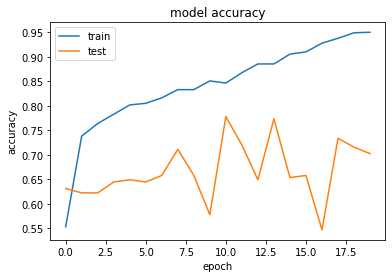

In [ ]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

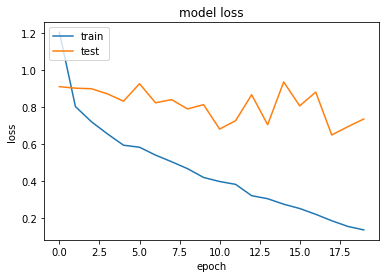

In [ ]:
# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn import metrics
matrix = metrics.confusion_matrix(y_test, y_pred.argmax(axis=1))

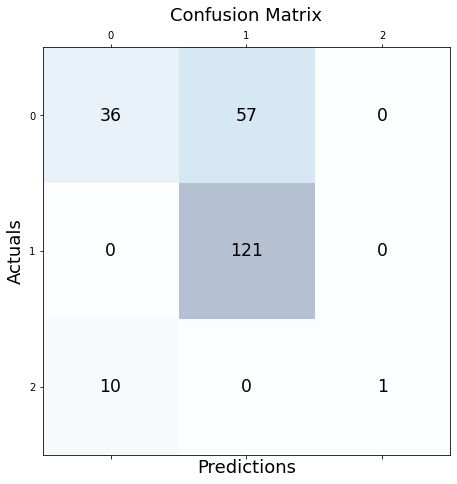

In [ ]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax.text(x=j, y=i,s=matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
!mv '/content/model.h5' '/content/drive/Shareddrives/475 Final Project'

# Load Trained Model

In [ ]:
model = keras.models.load_model('/content/drive/Shareddrives/475 Final Project/model.h5')
model.summary()

# GradCam Visualization

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
[a.name for a in model.layers[2].layers]

#model.layers[2].get_layer('block4_conv1').output

In [ ]:
# https://keras.io/examples/vision/grad_cam/

# The Grad-CAM algorithm
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 64, 64, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model):
    final_conv_layer = model.get_layer('vgg19').get_layer('block5_conv3')

    # Model connecting input image to final conv layer
    input = keras.Input(shape=model.inputs[0].shape[1:])
    output = input
    output = model.layers[0](input)
    output = model.layers[1](output)
    for layer in model.get_layer('vgg19').layers[:-1]: # slice to -1 to exclude final pooling layer
         output = layer(output)
    input_to_conv_model = keras.Model(input, output)

    # Model connecting final conv layer to predictions
    input = keras.Input(shape = final_conv_layer.output.shape[1:]) # 1: cuts out batch dimension
    output = input
    # pass through final pooling layer
    output = model.get_layer('vgg19').layers[-1](input)
    # iterate through layers after vgg
    for layer in model.layers[3:]: # 3: to slice after vgg19 layer
        output = layer(output)
    conv_to_predict_model = keras.Model(input, output)

    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        conv_output = input_to_conv_model(img_array)
        tape.watch(conv_output)
        # Compute class predictions
        preds = conv_to_predict_model(conv_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, conv_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    conv_output = conv_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(conv_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
# Test Gradcam
k = 65
image_path = non_covid_images[k]
image_size = (IMG_SIZE, IMG_SIZE)
img_array = get_img_array(image_path, size=image_size)
img_array = tf.image.rgb_to_grayscale(img_array)
#print(y_test[k], y_pred.argmax(axis=1)[k])
# Remove last layer's softmax
model.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model)

#Display heatmap
plt.matshow(heatmap)
plt.show()

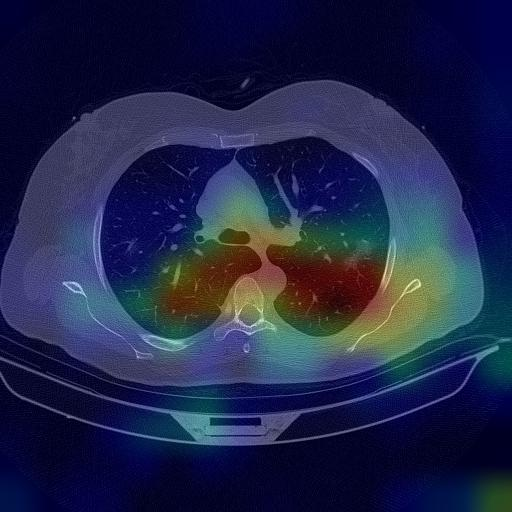

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

save_and_display_gradcam(covid_images[3], heatmap)

# Perform PCA

In [ ]:
from sklearn.decomposition import PCA
print(X_train.shape)
pca = PCA()
X_reduced = pca.fit_transform(X_train)

NameError: ignored

In [ ]:
BATCH_SIZE = 64
datagen.fit(X_reduced)

In [ ]:
history = model.fit(X_reduced, y_train_hot, batch_size=BATCH_SIZE,
               epochs=50,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_test, y_test_hot))

In [ ]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()